# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.



In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks 
import numpy as np
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0'

In [2]:
device = "mps" if torch.backends.mps.is_built() \
    else "gpu" if torch.cuda.is_available() else "cpu"
device

'gpu'

In [3]:


# define variable
var = torch.ones(3, requires_grad = True)
var

tensor([1., 1., 1.], requires_grad=True)

## y = x^3+2x

In [4]:
import numpy as np
# lets make basic backward propagation
# we have an equation that is y = x^3+2x
array = np.array([5.0], dtype=np.float32)

x = torch.tensor(array, requires_grad=True)

y = x**3 + 2*x
y

tensor([135.], grad_fn=<AddBackward0>)

# Hint grad(y) = 3x^2+2

grad(y,x=5) = 3*5^2+2 = 77

In [5]:
y.backward() # calculates gradients

# As I defined, variables accumulates gradients. In this part there is only one variable x.
# Therefore variable x should be have gradients
# Lets look at gradients with x.grad
print("gradients: ",x.grad)
print("real gradient",3*array[0]**2+2)


gradients:  tensor([77.])
real gradient 77.0


In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{|x|}\sum_i \left[(x_i + 2)^2 + 3\right]$$

You could imagine that $x$ are our parameters, and we want to optimize (either maximize or minimize) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [19]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [20]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


In [21]:
print(a)
print(b)
print(c)
print(y)

tensor([2., 3., 4.], grad_fn=<AddBackward0>)
tensor([ 4.,  9., 16.], grad_fn=<PowBackward0>)
tensor([ 7., 12., 19.], grad_fn=<AddBackward0>)
tensor(12.6667, grad_fn=<MeanBackward0>)


Using the statements above, we have created a computation graph that looks similar to the figure below:

<center style="width: 100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/pytorch_computation_graph.svg" width="200px"></center>

We calculate $a$ based on the inputs $x$ and the constant $2$, $b$ is $a$ squared, and so on. The visualization is an abstraction of the dependencies between inputs and outputs of the operations we have applied.
Each node of the computation graph has automatically defined a function for calculating the gradients with respect to its inputs, `grad_fn`. You can see this when we printed the output tensor $y$. This is why the computation graph is usually visualized in the reverse direction (arrows point from the result to the inputs). We can perform backpropagation on the computation graph by calling the function `backward()` on the last output, which effectively calculates the gradients for each tensor that has the property `requires_grad=True`:

In [22]:
y.backward()

x.grad will now contain the gradient  ∂𝑦/∂x , and this gradient indicates how a change in  𝐱  will affect output  𝑦  given the current input  𝐱=[0,1,2] :

In [23]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as PyTorch did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}
$$

Hence, with the input being $\mathbf{x}=[0,1,2]$, our gradients are $\partial y/\partial \mathbf{x}=[4/3,2,8/3]$. The previous code cell should have printed the same result.

## 1. Data (preparing and loading)



In [14]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

X[:10], y[:10]

# Q: create qua

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [15]:
len(X), len(y)

(50, 50)

In [16]:
0.8*50

40.0

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [17]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [18]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop={"size": 14});

# Method 1

In [19]:
import torch
from torch.autograd import Variable
import torch.nn as nn

# Assuming X_train and y_train are defined somewhere in your script

w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

def forward(x):
    return x * w + b

def loss_function(y_pred, y):
    return (y_pred - y) ** 2

# Using an optimizer (e.g., Stochastic Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=0.01)

# Training loop
for epoch in range(100):
    for x_val, y_val in zip(X_train, y_train):
        optimizer.zero_grad()  # Zero the gradients
        y_pred = forward(x_val)
        loss = loss_function(y_pred, y_val)
        loss.backward()
        optimizer.step()  # Perform a single optimization step

        if epoch % 10 == 0:
            print('Progress:', epoch, 'Loss:', loss.item())

print('w =', w.item(), 'b =', b.item())


Progress: 0 Loss: 0.4899999797344208
Progress: 0 Loss: 0.47886404395103455
Progress: 0 Loss: 0.4680596590042114
Progress: 0 Loss: 0.45755431056022644
Progress: 0 Loss: 0.4473169445991516
Progress: 0 Loss: 0.43731966614723206
Progress: 0 Loss: 0.42753636837005615
Progress: 0 Loss: 0.4179431200027466
Progress: 0 Loss: 0.4085177183151245
Progress: 0 Loss: 0.3992401659488678
Progress: 0 Loss: 0.3900921046733856
Progress: 0 Loss: 0.38105669617652893
Progress: 0 Loss: 0.37211886048316956
Progress: 0 Loss: 0.36326539516448975
Progress: 0 Loss: 0.3544841706752777
Progress: 0 Loss: 0.34576481580734253
Progress: 0 Loss: 0.33709827065467834
Progress: 0 Loss: 0.3284766376018524
Progress: 0 Loss: 0.3198937475681305
Progress: 0 Loss: 0.3113446831703186
Progress: 0 Loss: 0.30282536149024963
Progress: 0 Loss: 0.2943333089351654
Progress: 0 Loss: 0.28586703538894653
Progress: 0 Loss: 0.27742621302604675
Progress: 0 Loss: 0.26901161670684814
Progress: 0 Loss: 0.2606249451637268
Progress: 0 Loss: 0.25226

In [20]:
preds =forward(X_test)
preds

tensor([[0.8604],
        [0.8744],
        [0.8885],
        [0.9025],
        [0.9165],
        [0.9305],
        [0.9446],
        [0.9586],
        [0.9726],
        [0.9866]], grad_fn=<AddBackward0>)

# Method 2

## Method 3


#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:
```
from torch import nn

class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass
```

In [22]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
    
    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True, # <- can this parameter be updated via gradient descent?
                                         dtype=torch.float)) # <- PyTorch loves the datatype torch.float32 
    
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

hint

In [23]:
Weights = torch.distributions.Uniform(0, 0.1).sample((2,))
Weights

tensor([0.0180, 0.0865])

In [24]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
   
    weights = torch.distributions.Uniform(0, 0.1).sample((2,))
        # make weights torch parameters
    self.weights = nn.Parameter(weights)    
    
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) :
    w, b = self.weights
    return x*w+b# this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us 
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation 

See more of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html 

In [25]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.0882, 0.0915], requires_grad=True)]

In [26]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.0882, 0.0915]))])

### Making prediction using `torch.inference_mode()`



In [27]:
y_preds = model_0( X_test) 
y_preds

tensor([[0.1621],
        [0.1638],
        [0.1656],
        [0.1674],
        [0.1691],
        [0.1709],
        [0.1727],
        [0.1744],
        [0.1762],
        [0.1780]], grad_fn=<AddBackward0>)

In [28]:
 with torch.no_grad():
   y_preds = model_0(X_test)

y_preds

tensor([[0.1621],
        [0.1638],
        [0.1656],
        [0.1674],
        [0.1691],
        [0.1709],
        [0.1727],
        [0.1744],
        [0.1762],
        [0.1780]])

In [29]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
  

# # You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred


See more on inference mode here - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=cnKavO9iTgwQ-rfri6u7PQ 

In [30]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

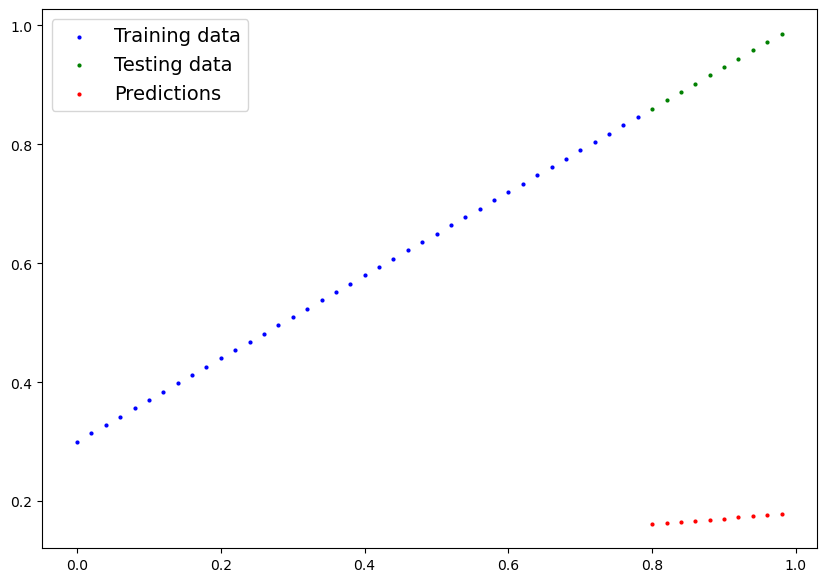

In [31]:
plot_predictions(predictions=y_preds)

## Method 3 --> Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [134]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.0882, 0.0915], requires_grad=True)]

In [135]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.0882, 0.0915]))])

In [34]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch


In [35]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 300

# Track different values
epoch_count = [] 
loss_values = []
test_loss_values = [] 

### Training
# 0. Loop through the data
for epoch in range(epochs): 
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Perform backpropagation on the loss with respect to the parameters of the model (calculate gradients of each parameter)
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass 
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happenin'
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [138]:
import numpy as np
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.44709116, 0.33188108, 0.21667106, 0.13526821, 0.10208862,
        0.08867105, 0.08221509, 0.07795461, 0.07437216, 0.07088216,
        0.06739216, 0.06395335, 0.06051748, 0.05708854, 0.05364973,
        0.05021555, 0.04678492, 0.04334612, 0.03991362, 0.03648131,
        0.0330425 , 0.02961169, 0.02617769, 0.02273888, 0.01930976,
        0.01587407, 0.01243627, 0.00900782, 0.00557045, 0.00213433],
       dtype=float32),
 [tensor(0.7395),
  tensor(0.6048),
  tensor(0.4701),
  tensor(0.3583),
  tensor(0.2847),
  tensor(0.2389),
  tensor(0.2098),
  tensor(0.1906),
  tensor(0.1789),
  tensor(0.1679),
  tensor(0.1569),
  tensor(0.1486),
  tensor(0.1410),
  tensor(0.1327),
  tensor(0.1245),
  tensor(0.1169),
  tensor(0.1086),
  tensor(0.1003),
  tensor(0.0928),
  tensor(0.0845),
  tensor(0.0762),
  tensor(0.0686),
  tensor(0.0604),
  tensor(0.0521),
  tensor(0.0445),
  tensor(0.0362),
  tensor(0.0286),
  tensor(0.0204),
  tensor(0.0121),
  tensor(0.0045)])

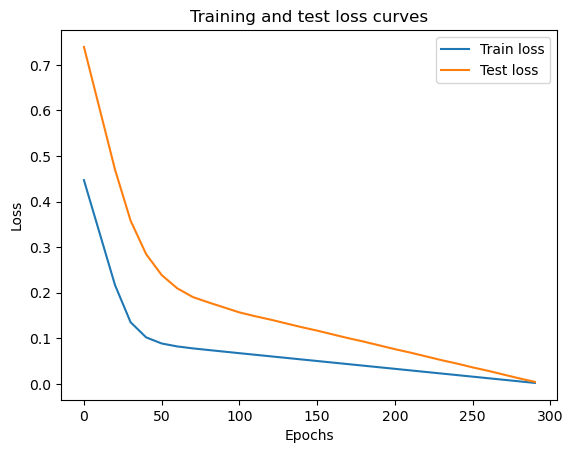

In [93]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [36]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [37]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [141]:
weight, bias

(0.7, 0.3)

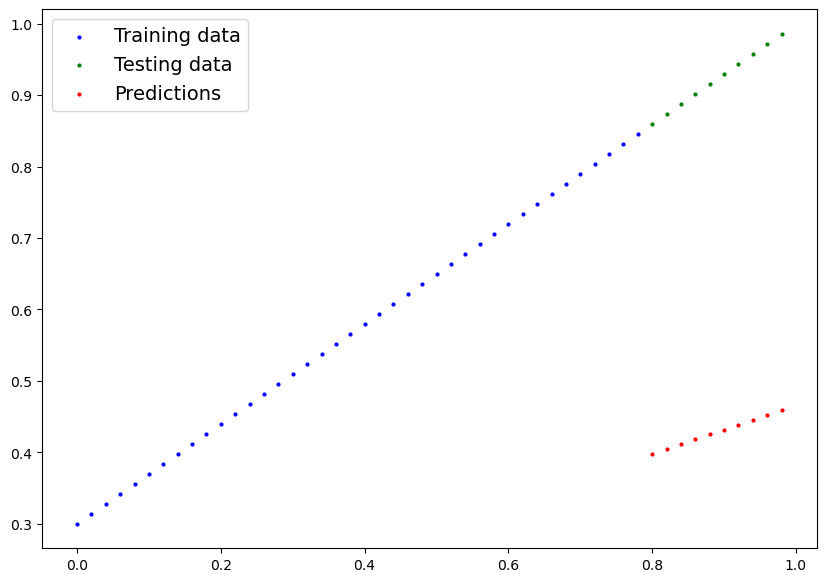

In [38]:
plot_predictions(predictions=y_preds);

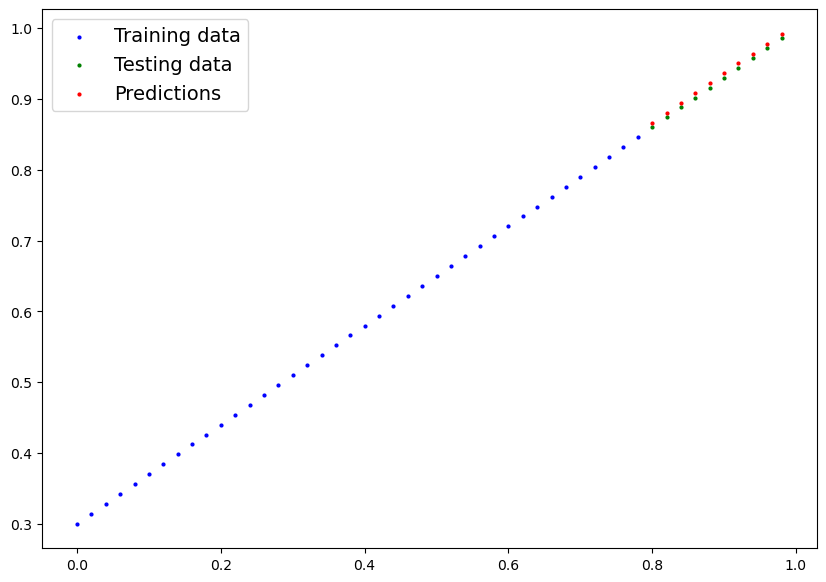

In [143]:
plot_predictions(predictions=y_preds_new);

## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format 
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary 

PyTorch save & load code tutorial + extra-curriculum - https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [144]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [145]:
!ls -l models

total 8
-rw-r--r--  1 tuchsanai  staff  935 Aug 30 19:13 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that. 

In [146]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6975, 0.3085]))])

In [147]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [148]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6975, 0.3085]))])

In [102]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8665],
        [0.8804],
        [0.8944],
        [0.9083],
        [0.9223],
        [0.9362],
        [0.9502],
        [0.9641],
        [0.9781],
        [0.9920]])

In [103]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8665],
        [0.8804],
        [0.8944],
        [0.9083],
        [0.9223],
        [0.9362],
        [0.9502],
        [0.9641],
        [0.9781],
        [0.9920]])

In [104]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [105]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.0.dev20220825'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data 

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop={"size": 14});

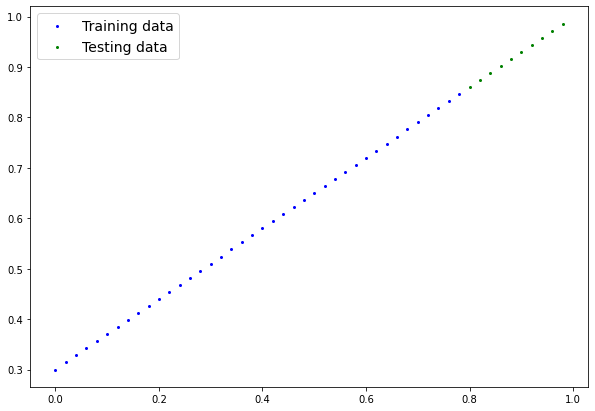

In [ ]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [ ]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_1.state_dict() 

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data) 
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0: 
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
weight, bias 

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

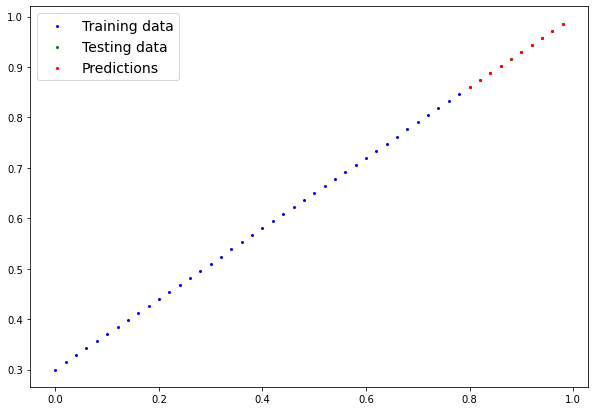

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Load a PyTorch model

# Create a new instance of lienar regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')